In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Utility Function

### Function to create a dataframe of percentage of NaN values for each column of the dataframe

In [2]:
def nan_df_create(data):

    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})

    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)

    return df

### Function to plot Bar Plots of NaN percentages for each Column with missing values

In [3]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):

    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")

        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

### Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.

In [4]:
class correlation_matrix:

    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True,
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):

        '''Function to initialize the class members.'''


        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap

    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap

        '''

        print('-' * 100)
        #building the correlation dataframe
        #self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()
        numerical_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis=1).select_dtypes(include=np.number)
        self.corr_data = numerical_data.corr()
        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)

    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        '''

        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)

        return top_corr_target_df.iloc[:target_top_columns]

### Function to Phi_k matrix for categorical features

In [5]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):

    '''
    Function to Phi_k matrix for categorical features

    '''

    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()

    print('-'*100)

    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)

    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100)

### Function to plot Categorical Variables Bar Plots

In [6]:
def plot_categorical_variables_bar(data, column_name, figsize=(18,6), percentage_display=True, plot_defaulter=True, rotation=0, horizontal_adjust=0, fontsize_percent='xx-small'):
    '''
    Function to plot Categorical Variables Bar Plots.
    Limits the number of categories displayed to 10 if there are more than 10 unique categories.
    '''

    # Retrieve and limit the number of categories to plot
    unique_categories = data[column_name].unique()
    print(f"Total Number of unique categories of {column_name} = {len(unique_categories)}")

    plt.figure(figsize=figsize, tight_layout=False)
    sns.set(style='whitegrid', font_scale=1.2)

    # Plotting overall distribution of category, limited to the first 10 if more than 10
    plt.subplot(1, 2, 1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)[:10]
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot, palette='Set1')

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.2f}%'.format(p.get_height() * 100 / total_datapoints), fontsize=fontsize_percent)

    plt.xlabel(column_name, labelpad=10)
    plt.title(f'Distribution of {column_name}', pad=20)
    plt.xticks(rotation=rotation)
    plt.ylabel('Counts')

    # Plotting distribution of category for Defaulters, limited to the first 10 if more than 10
    if plot_defaulter:
        plt.subplot(1, 2, 2)
        percentage_defaulter_per_category = (data[column_name][data['TARGET'] == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending=False)[:10]
        sns.barplot(x=percentage_defaulter_per_category.index, y=percentage_defaulter_per_category, palette='Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad=10)
        plt.xticks(rotation=rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad=20)
    plt.show()

### Function to plot categorical variables Pie Plots

In [7]:
def plot_categorical_variables_bar(data, column_name, figsize=(18,6), percentage_display=True, plot_defaulter=True, rotation=0, horizontal_adjust=0, fontsize_percent='small'):
    '''
    Function to plot Categorical Variables Bar Plots.
    Limits the number of categories displayed to 10 if there are more than 10 unique categories.
    Displays percentage in the middle of the bars with improved readability.
    '''

    # Retrieve and limit the number of categories to plot
    unique_categories = data[column_name].unique()
    print(f"Total Number of unique categories of {column_name} = {len(unique_categories)}")

    plt.figure(figsize=figsize, tight_layout=False)
    sns.set(style='whitegrid', font_scale=1.2)

    # Plotting overall distribution of category, limited to the first 10 if more than 10
    plt.subplot(1, 2, 1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)[:10]
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot, palette='Set1')

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            # Calculate the percentage for each bar
            percentage = p.get_height() * 100 / total_datapoints
            # Get the position to center the percentage text on the bar
            x_position = p.get_x() + p.get_width() / 2
            y_position = p.get_height() / 2  # Positioning text in the middle of the bar
            # Adjust the text to make it more readable
            ax.text(x_position, y_position, f'{percentage:1.2f}%', ha='center', va='center', fontsize=fontsize_percent, color='black', fontweight='bold')

    plt.xlabel(column_name, labelpad=10)
    plt.title(f'Distribution of {column_name}', pad=20)
    plt.xticks(rotation=rotation)
    plt.ylabel('Counts')

    # Plotting distribution of category for Defaulters, limited to the first 10 if more than 10
    if plot_defaulter:
        plt.subplot(1, 2, 2)
        percentage_defaulter_per_category = (data[column_name][data['TARGET'] == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending=False)[:10]
        sns.barplot(x=percentage_defaulter_per_category.index, y=percentage_defaulter_per_category, palette='Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad=10)
        plt.xticks(rotation=rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad=20)
        
        if percentage_display:
            for p in plt.gca().patches:
                percentage = p.get_height()
                x_position = p.get_x() + p.get_width() / 2
                y_position = p.get_height() / 2
                # Adjust the text to make it more readable
                plt.text(x_position, y_position, f'{percentage:1.2f}%', ha='center', va='center', fontsize=fontsize_percent, color='black', fontweight='bold')

    plt.show()

#### Function to print the basic stats such as unique categories and their counts for categorical variables

In [8]:
def print_unique_categories(data, column_name, show_counts = False):

    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables

    '''

    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)

    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)

### Function to plot CDF of a continuour variable

In [9]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):

    '''
    Function to plot CDF of a continuour variable

    '''


    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

### Function to print percentile values for given column


In [10]:
def print_percentiles(data, column_name, percentiles = None):

    '''
    Function to print percentile values for given column

    '''

    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

### Function to plot continuous variables distribution

In [11]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):

    '''
    Function to plot continuous variables distribution

    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')

    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)

        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]

            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]

            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')

        if ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

### Function to detect outlier

In [12]:
def detect_outliers_iqr(df, column):
    """Detect outliers using IQR."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

def plot_outliers(df):
    """Plot all numeric columns in a single figure."""
    numeric_columns = df.select_dtypes(include=['number']).columns
    num_cols = len(numeric_columns)
    
    # Create subplots
    fig, axes = plt.subplots(nrows=(num_cols // 3) + 1, ncols=3, figsize=(20, 5 * ((num_cols // 3) + 1)))
    axes = axes.flatten()  # Flatten the axes for easy iteration
    
    # Plot each column in its own subplot
    for i, column in enumerate(numeric_columns):
        # Detect outliers
        outliers = detect_outliers_iqr(df, column)
        
        # Plot the boxplot
        sns.boxplot(x=df[column], ax=axes[i], color='lightblue')
        
        # Highlight outliers if they exist
        if not outliers.empty:
            axes[i].scatter(outliers[column], [1] * len(outliers), color='red', label='Outliers')
        
        axes[i].set_title(f'Outliers in {column}')
        axes[i].legend()
    
    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
application_train = pd.read_csv("C:\\Users\\LENOVO\\Desktop\\dseb63_final_project_DP_dataset\\dseb63_application_train.csv")
application_test = pd.read_csv("C:\\Users\\LENOVO\\Desktop\\dseb63_final_project_DP_dataset\\dseb63_application_test.csv")

In [14]:
cc_balance = pd.read_csv("C:\\Users\\LENOVO\\Desktop\\dseb63_final_project_DP_dataset\\dseb63_credit_card_balance.csv")

# **credit_card_balance.csv**

##### **Mô tả**

Bảng này bao gồm dữ liệu hàng tháng liên quan đến một hoặc nhiều thẻ tín dụng mà người nộp đơn đã sử dụng với Credit Risk Dataset. Bảng chứa các trường như số dư, hạn mức tín dụng, số tiền rút, v.v., cho từng tháng của thẻ tín dụng.


<h4>Dữ Liệu</h4>

In [15]:
print(f'The shape of credit_card_balance.csv is: {cc_balance.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(cc_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(cc_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')
print('-'*100)

print(f'Number of duplicate values in credit_card_balance: {cc_balance.shape[0] - cc_balance.duplicated().shape[0]}')
print('-'*100)
display(cc_balance.head(5))

The shape of credit_card_balance.csv is: (3227965, 23)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 87452
Number of unique SK_ID_CURR in credit_card_balance.csv are: 86905
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 69536
Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: 17369
----------------------------------------------------------------------------------------------------
Number of duplicate values in credit_card_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,2582071,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.0,2250.0,...,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0,87788
1,2582071,-82,16809.210,67500,0.0,0.0,0.0,0.0,3375.0,9000.0,...,16809.210,0.0,0,0.0,0.0,18.0,Active,0,0,87788
2,2582071,-84,27577.890,67500,0.0,0.0,0.0,0.0,3375.0,4500.0,...,27577.890,0.0,0,0.0,0.0,16.0,Active,0,0,87788
3,2582071,-7,65159.235,45000,0.0,0.0,0.0,0.0,2250.0,2250.0,...,65609.235,0.0,0,0.0,0.0,63.0,Active,0,0,87788
4,2582071,-59,70475.850,67500,24750.0,24750.0,0.0,0.0,3375.0,4500.0,...,70475.850,4.0,4,0.0,0.0,41.0,Active,0,0,87788


##### **Quan sát và Kết luận**

<ol>
    <li>Bảng `credit_card_balance.csv` có khoảng 3.84 triệu hàng, mỗi hàng tương ứng với trạng thái hàng tháng của thẻ tín dụng mà người nộp đơn đã sử dụng với Credit Risk Dataset. Bảng này chứa 23 đặc trưng mô tả các thống kê về trạng thái thẻ tín dụng từng tháng, như số dư, số tiền rút, số lần rút tiền, trạng thái, v.v.</li>
    <li>Có 104.3 nghìn thẻ tín dụng duy nhất được liệt kê trong bảng này.</li>
    <li>Trong số 104.3 nghìn thẻ tín dụng, có 103.5 nghìn `SK_ID_CURR` duy nhất. Điều này có nghĩa là hầu hết người nộp đơn chỉ sở hữu một thẻ tín dụng, và chỉ một số ít có nhiều hơn một thẻ. Các `SK_ID_CURR` này là ID của những người hiện đang nộp đơn xin vay.</li>
    <li>Trong số 103.5 nghìn `SK_ID_CURR` duy nhất, 86.9 nghìn thuộc về tập huấn luyện (`training set`), và 16.6 nghìn thuộc về tập kiểm tra (`test application set`).</li>
    <li>Trong tổng số 307 nghìn người nộp đơn trong bảng `application_train`, chỉ có 86.9 nghìn trong số đó từng sở hữu thẻ tín dụng với Credit Risk Dataset.</li>
</ol>


#### NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 9 columns


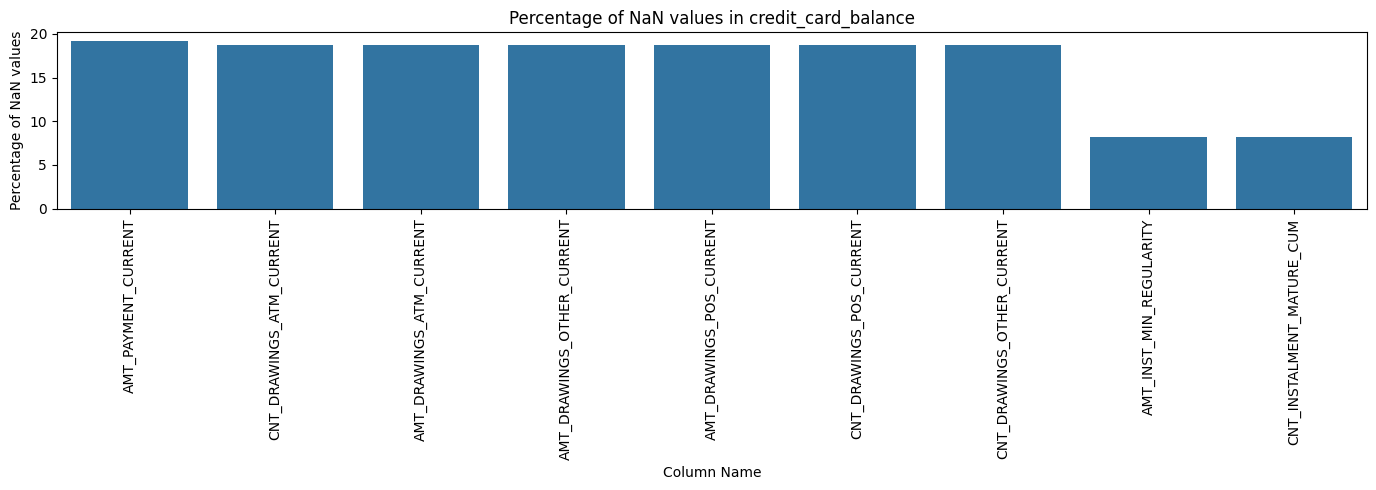

----------------------------------------------------------------------------------------------------


In [16]:
cc_balance_nan = nan_df_create(cc_balance)
print('-'*100)
plot_nan_percent(cc_balance_nan, 'credit_card_balance', tight_layout = False, rotation = 90, figsize = (14,5))
print('-'*100)
del cc_balance_nan

##### **Quan sát và Kết luận**

<ol>
    <li>Trong tổng số 23 đặc trưng, có 9 đặc trưng chứa một số giá trị NaN.</li>
    <li>Nếu xem xét tỷ lệ phần trăm các giá trị NaN, chúng thấp hơn đáng kể so với các bảng khác mà chúng ta đã xem xét cho đến nay.</li>
    <li>7 trong số các đặc trưng này có khoảng 20% giá trị NaN. Các đặc trưng này chủ yếu liên quan đến số tiền rút và số lần rút tiền. Hai đặc trưng còn lại liên quan đến thống kê các khoản trả góp.</li>
</ol>


<b>Hợp biến TARGETS từ application_train đến credit_card_balance table.</b>

In [17]:
print("-"*100)
print("Merging TARGET with credit_card_balance Table")
#cc_balance_merged = application_train.iloc[:,:2].merge(cc_balance, on = 'SK_ID_CURR', how = 'left')
cc_balance_merged = application_train[['SK_ID_CURR', application_train.columns[1]]].merge(cc_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


#### **Ma trận Tương Quan của Các Đặc Trưng**


----------------------------------------------------------------------------------------------------


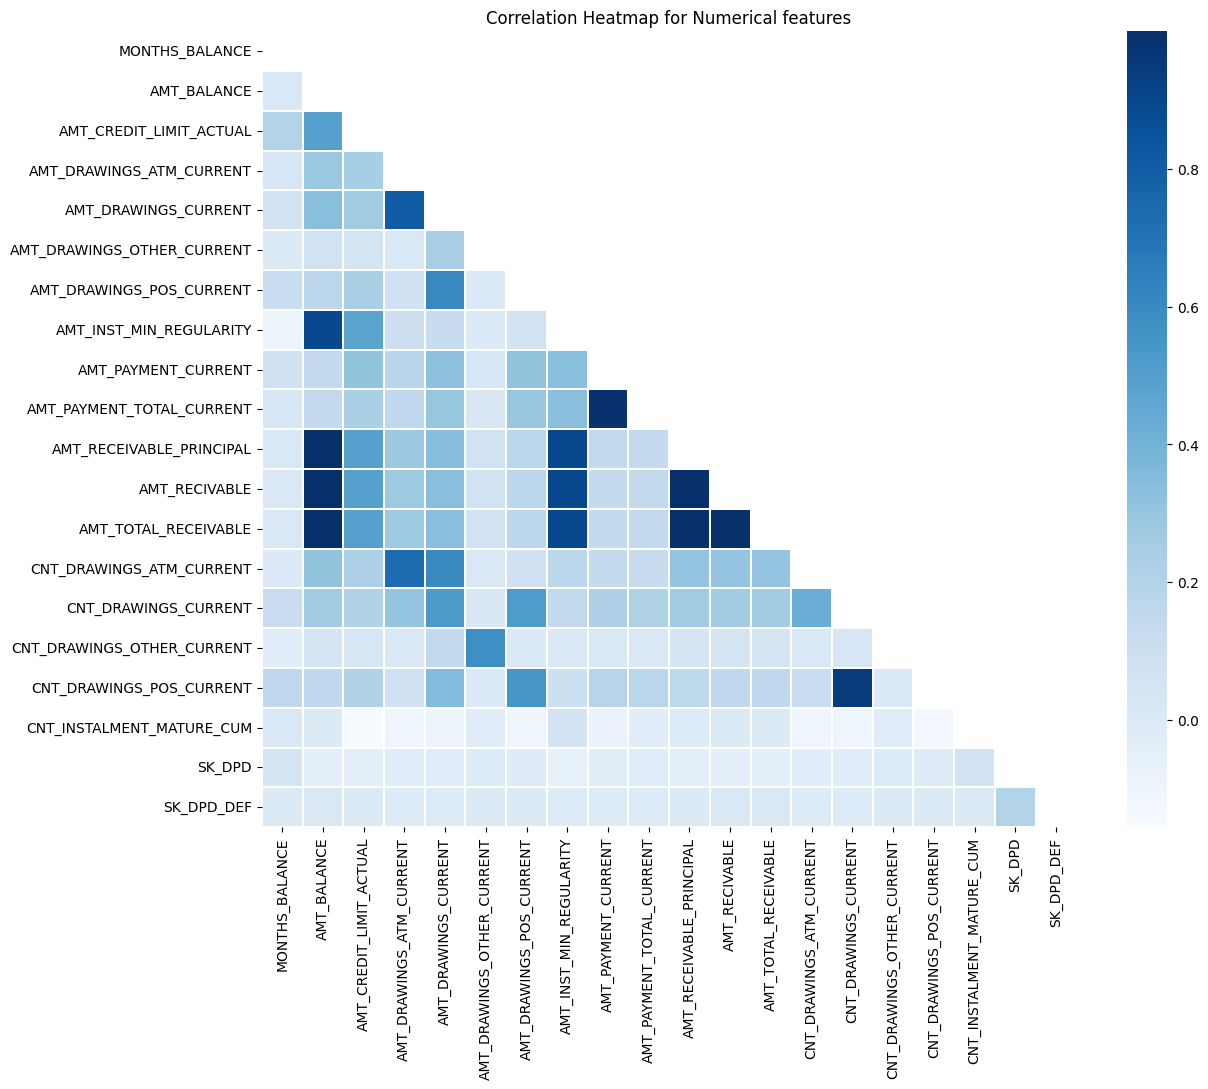

----------------------------------------------------------------------------------------------------


In [18]:
corr_mat = correlation_matrix(cc_balance_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

In [19]:
#Seeing the top columns with highest phik-correlation with the target variable in credit_card_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

,Column Name,Phik-Correlation
1,AMT_BALANCE,0.063771
12,AMT_TOTAL_RECEIVABLE,0.063669
11,AMT_RECIVABLE,0.063441
10,AMT_RECEIVABLE_PRINCIPAL,0.063251
0,MONTHS_BALANCE,0.048491
7,AMT_INST_MIN_REGULARITY,0.040593
17,CNT_INSTALMENT_MATURE_CUM,0.036092
13,CNT_DRAWINGS_ATM_CURRENT,0.028858
14,CNT_DRAWINGS_CURRENT,0.027678
2,AMT_CREDIT_LIMIT_ACTUAL,0.027012


----------------------------------------------------------------------------------------------------


##### **Quan sát và Kết luận:**

<ol>
    <li>Biểu đồ nhiệt phía trên cho thấy trực quan mối tương quan giữa các đặc trưng trong bảng `credit_card_balance`.</li>
    <li>Từ ma trận tương quan, ta thấy một số cặp đặc trưng có mối tương quan cao. Cụ thể:
        <ul>
            <li>`AMT_RECEIVABLE_PRINCIPLE`, `AMT_RECIVABLE`, `AMT_TOTAL_RECEIVABLE` và `AMT_BALANCE`</li>
            <li>Có mối tương quan cao giữa 3 cột `AMT_RECEIVABLE` này.</li>
            <li>`AMT_PAYMENT_TOTAL_CURRENT` và `AMT_PAYMENT_CURRENT`</li>
        </ul>
    </li>
    <li>Các nhóm đặc trưng thứ 2 và thứ 3 có mối tương quan cao là dễ hiểu vì chúng phản ánh các khía cạnh tương tự.</li>
    <li>Mối tương quan của các đặc trưng với biến `Target` không đáng kể, điều này cho thấy không có mối quan hệ tuyến tính giữa các đặc trưng và biến mục tiêu.</li>
</ol>


### **Phân phối của Biến Phân Loại `NAME_CONTRACT_STATUS`**



----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_STATUS' are:
[nan 'Active' 'Completed' 'Signed' 'Sent proposal' 'Refused' 'Demand'
 'Approved']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_STATUS = 8


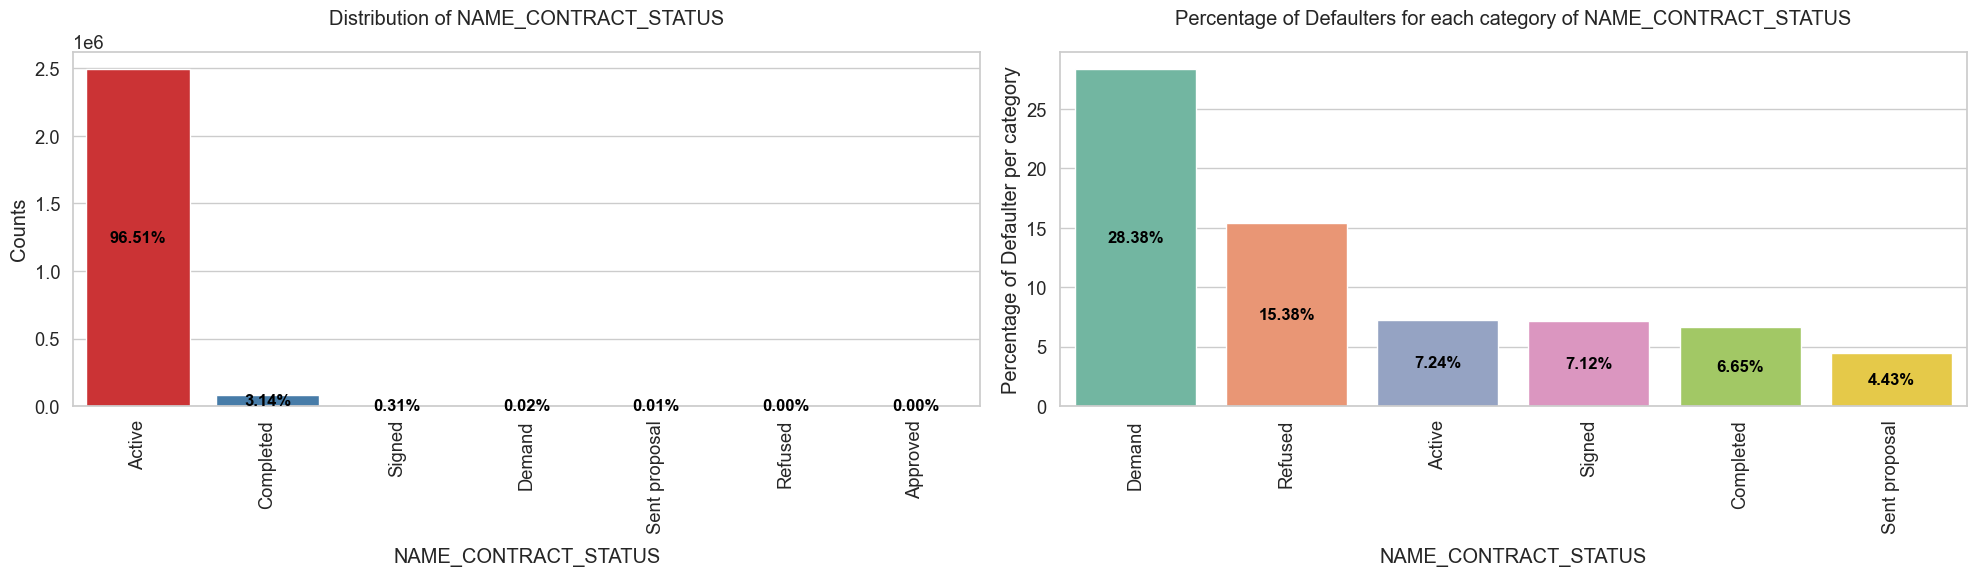

In [20]:

print_unique_categories(cc_balance_merged, 'NAME_CONTRACT_STATUS')

plot_categorical_variables_bar(cc_balance_merged, 'NAME_CONTRACT_STATUS', rotation = 90, figsize = (20, 6))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và tỷ lệ vỡ nợ theo các trạng thái hợp đồng trong biến `NAME_CONTRACT_STATUS`. Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phần lớn các hợp đồng thuộc trạng thái <strong>Active</strong>, chiếm <strong>96.51%</strong> tổng số hợp đồng. Các trạng thái khác như <strong>Completed</strong>, <strong>Signed</strong>, và <strong>Demand</strong> chỉ chiếm tỷ lệ nhỏ (<strong>3.14%</strong>, <strong>0.31%</strong>, và <strong>0.02%</strong> tương ứng).</li>
    <li>Tỷ lệ vỡ nợ cao nhất thuộc về trạng thái <strong>Demand</strong>, với <strong>28.38%</strong>. Điều này cho thấy rằng những hợp đồng yêu cầu thanh toán có rủi ro vỡ nợ cao nhất.</li>
    <li>Trạng thái <strong>Refused</strong> cũng có tỷ lệ vỡ nợ khá cao (<strong>15.38%</strong>), mặc dù số lượng các hợp đồng trong trạng thái này rất nhỏ.</li>
    <li>Ngược lại, các trạng thái <strong>Sent proposal</strong>, <strong>Completed</strong>, và <strong>Signed</strong> có tỷ lệ vỡ nợ thấp hơn, lần lượt là <strong>4.43%</strong>, <strong>6.65%</strong>, và <strong>7.12%</strong>.</li>
    <li>Trạng thái <strong>Active</strong>, mặc dù chiếm phần lớn các hợp đồng, chỉ có tỷ lệ vỡ nợ là <strong>7.24%</strong>, thấp hơn so với các trạng thái khác như <strong>Demand</strong> và <strong>Refused</strong>.</li>
</ol>

**Kết luận:**
- Trạng thái hợp đồng là một chỉ số quan trọng để đánh giá rủi ro vỡ nợ, với trạng thái <strong>Demand</strong> và <strong>Refused</strong> có tỷ lệ vỡ nợ cao nhất.
- Trạng thái <strong>Active</strong> chiếm đa số và có tỷ lệ vỡ nợ thấp hơn so với các trạng thái rủi ro cao như <strong>Demand</strong>.
- Việc phân tích chi tiết hơn các trạng thái này có thể giúp xác định các yếu tố rủi ro tiềm năng và cải thiện dự đoán tín dụng.


## **Vẽ Biểu Đồ cho Các Biến Liên Tục**  

Đầu tiên, chúng ta sẽ nhóm theo trường `SK_ID_PREV` và tính giá trị trung bình, để có được một hàng trung bình đại diện cho mỗi khoản vay trước đây mà khách hàng đã có.


In [21]:
#cc_balance_merged = cc_balance_merged.groupby('SK_ID_PREV').mean()
numeric_features = cc_balance_merged.select_dtypes(include=['number']).columns
cc_balance_merged = cc_balance_merged.groupby('SK_ID_PREV')[numeric_features].mean()

# Representative variables for both distribution and outlier visualization

### **Phân phối của Biến Liên Tục `MONTHS_BALANCE`**

Cột này mô tả số tháng kể từ lần đầu tiên xuất hiện dữ liệu về số dư tín dụng trong tập dữ liệu.

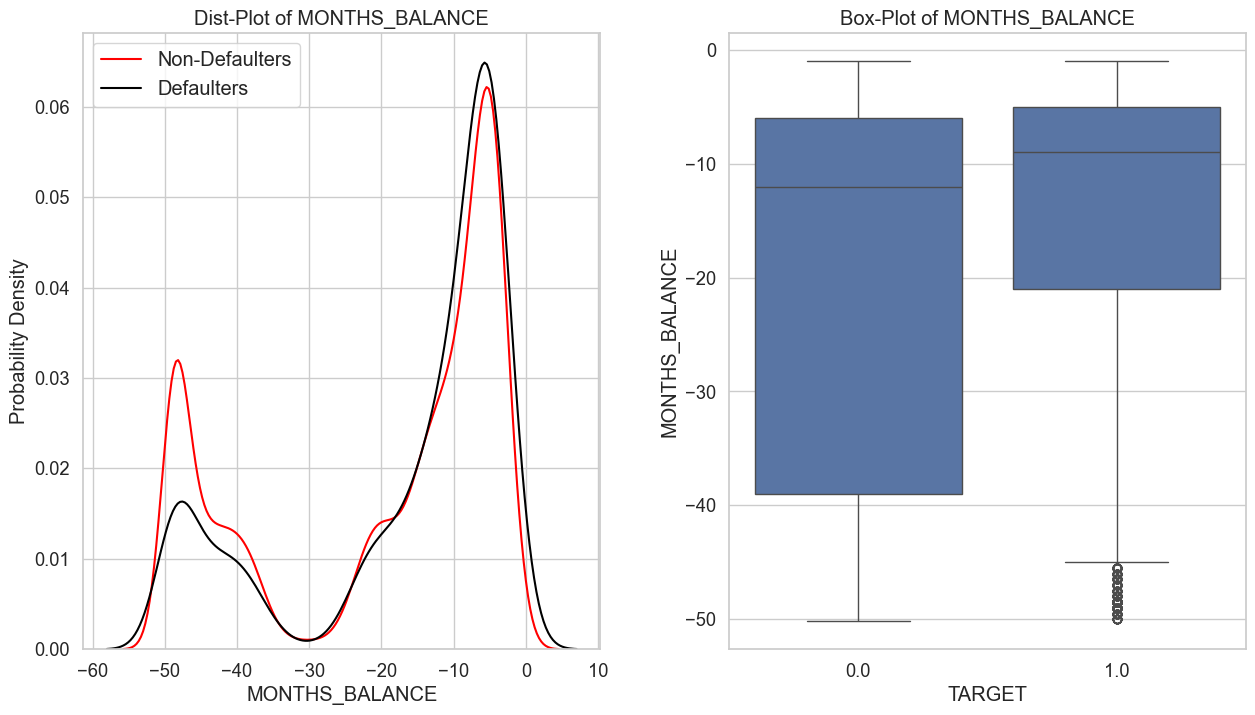

In [22]:
plot_continuous_variables(cc_balance_merged, 'MONTHS_BALANCE', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `MONTHS_BALANCE` (số tháng trước thời điểm hiện tại) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `MONTHS_BALANCE` cho thấy phần lớn các giá trị nằm trong khoảng từ <strong>-60 đến 0</strong>, với đỉnh tập trung quanh <strong>-1 đến -5</strong>. Đây là những tháng gần thời điểm hiện tại.</li>
    <li>Nhóm người không vỡ nợ có một đỉnh phụ đáng kể ở khoảng <strong>-50</strong>, điều này có thể cho thấy một số lượng lớn các hợp đồng cũ hơn trong nhóm này.</li>
    <li>Biểu đồ hộp (phải) chỉ ra rằng trung vị của `MONTHS_BALANCE` trong cả hai nhóm là tương tự, với giá trị gần <strong>-15</strong>. Phạm vi giá trị chính yếu của cả hai nhóm nằm trong khoảng từ <strong>-50 đến 0</strong>.</li>
    <li>Một số giá trị ngoại lệ (outliers) ở nhóm vỡ nợ (Target = 1) cho thấy một số hợp đồng có giá trị `MONTHS_BALANCE` thấp hơn <strong>-50</strong>, phản ánh những hợp đồng rất cũ.</li>
</ol>

**Kết luận:**
- Biến `MONTHS_BALANCE` có phân phối tập trung ở các tháng gần thời điểm hiện tại (từ <strong>-1 đến -5</strong>), với một số khác biệt nhỏ giữa hai nhóm.
- Đỉnh phụ ở nhóm không vỡ nợ (khoảng <strong>-50</strong>) cần được phân tích thêm để xác định nguyên nhân.
- Biến này có thể hữu ích trong việc phân tích rủi ro tín dụng, đặc biệt nếu được kết hợp với các biến thời gian khác.



### **Phân phối của Biến Liên Tục `AMT_PAYMENT_TOTAL_CURRENT`**

Cột này mô tả tổng số tiền đã thanh toán (bao gồm cả gốc và lãi) trong tháng hiện tại.

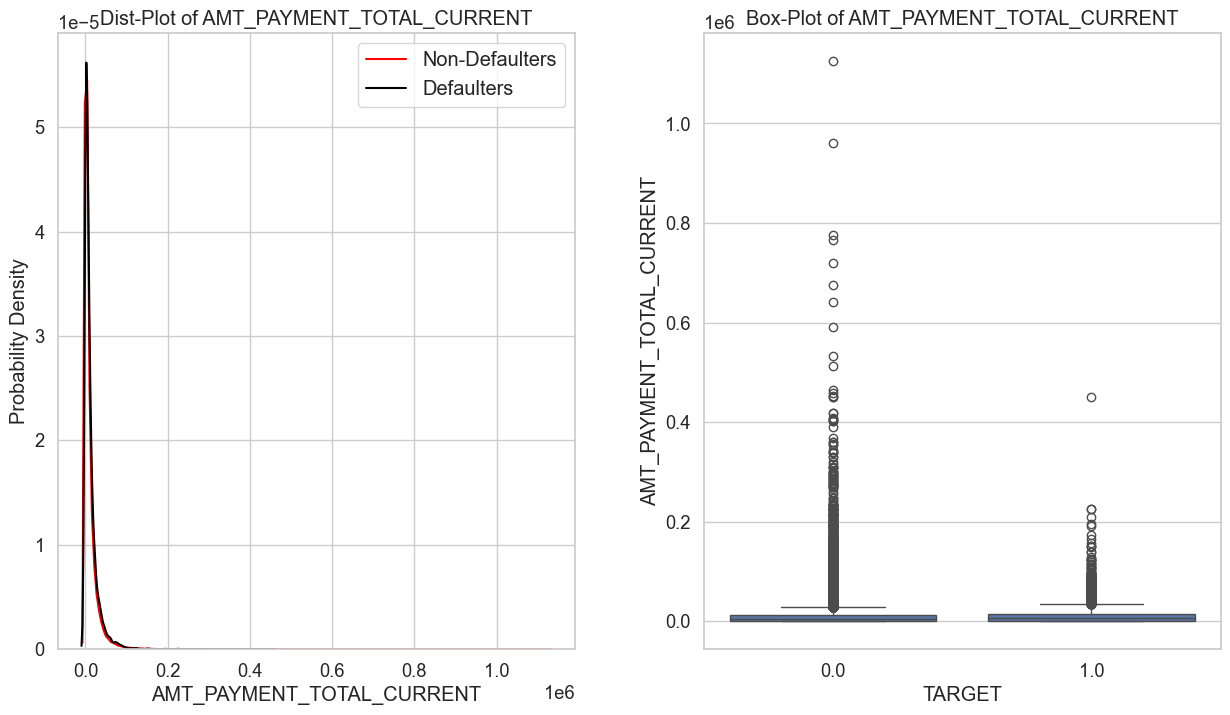

In [23]:

plot_continuous_variables(cc_balance_merged, 'AMT_PAYMENT_TOTAL_CURRENT', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `AMT_PAYMENT_TOTAL_CURRENT` (tổng số tiền thanh toán hiện tại) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `AMT_PAYMENT_TOTAL_CURRENT` cho cả hai nhóm (vỡ nợ và không vỡ nợ) rất giống nhau, với phần lớn các giá trị tập trung ở mức rất thấp (<strong>dưới 0.1 triệu</strong>).</li>
    <li>Biểu đồ phân phối (trái) cho thấy rằng các nhóm có sự chồng lấp lớn, phản ánh rằng biến này không có sự phân biệt rõ rệt giữa người vỡ nợ và không vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) chỉ ra rằng trung vị của `AMT_PAYMENT_TOTAL_CURRENT` trong cả hai nhóm nằm ở mức rất thấp (<strong>gần 0</strong>), với khoảng giá trị chính yếu không vượt quá <strong>0.05 triệu</strong>.</li>
    <li>Một số giá trị ngoại lệ (outliers) xuất hiện ở cả hai nhóm, với tổng số tiền thanh toán vượt mức <strong>1 triệu</strong>. Những giá trị này là hiếm nhưng cần được phân tích thêm để hiểu rõ tính chất của chúng.</li>
</ol>

**Kết luận:**
- Biến `AMT_PAYMENT_TOTAL_CURRENT` có phân phối tập trung ở mức thấp và không có sự khác biệt rõ rệt giữa hai nhóm (vỡ nợ và không vỡ nợ).
- Các giá trị ngoại lệ (tổng thanh toán lớn) cần được xem xét kỹ lưỡng hơn để đánh giá tác động tiềm năng.
- Biến này có thể không đủ mạnh để phân biệt rủi ro tín dụng nếu được sử dụng độc lập, nhưng có thể hữu ích khi được kết hợp với các yếu tố khác.



### **Phân phối của Biến Liên Tục `SK_DPD`**

Cột này mô tả số ngày chậm thanh toán gần nhất trên tài khoản thẻ tín dụng.

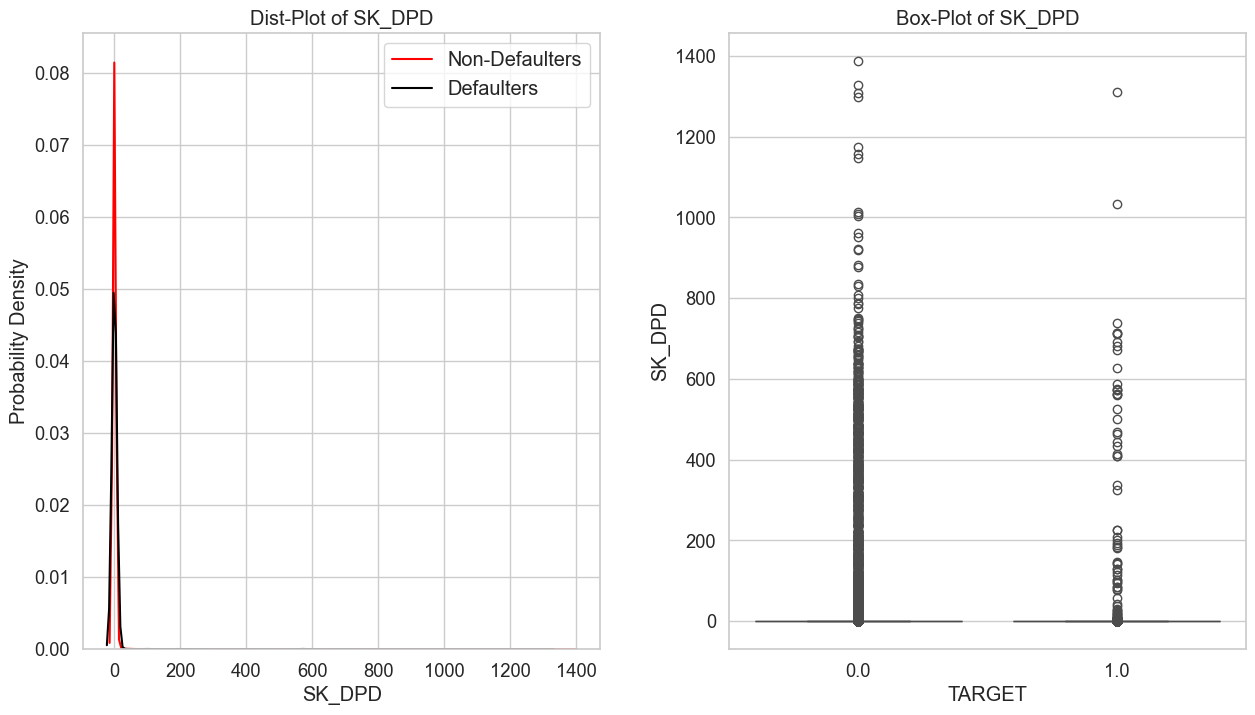

In [24]:
plot_continuous_variables(cc_balance_merged, 'SK_DPD', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `SK_DPD` (số ngày chậm trả nợ kể từ ngày thanh toán đầu tiên) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `SK_DPD` cho thấy phần lớn các khoản vay có số ngày chậm trả nợ gần như bằng không, cho thấy hầu hết các khoản vay được trả đúng hạn.</li>
    <li>Biểu đồ phân phối (trái) chỉ ra sự tương đồng lớn về phân phối giữa người vỡ nợ và không vỡ nợ, với đỉnh chính của cả hai nhóm nằm gần giá trị 0.</li>
    <li>Biểu đồ hộp (phải) cho thấy một số giá trị ngoại lệ (outliers) xuất hiện, đặc biệt trong nhóm người vỡ nợ (Target = 1), với một số khoản vay có `SK_DPD` cao hơn đáng kể so với mức trung bình, phản ánh những trường hợp chậm trả nợ nghiêm trọng.</li>
    <li>Mặc dù vậy, trung vị của cả hai nhóm nằm ở mức thấp, điều này chỉ ra rằng đa số các khoản vay, dù vỡ nợ hay không, đều không có hoặc có rất ít ngày chậm trả.</li>
</ol>

**Kết luận:**
- Biến `SK_DPD` cho thấy phần lớn các khoản vay được thanh toán đúng hạn, nhưng vẫn tồn tại các trường hợp chậm trả nợ nghiêm trọng được thể hiện qua các giá trị ngoại lệ.
- Để đánh giá rủi ro tín dụng, cần phải xem xét chi tiết hơn các trường hợp ngoại lệ này.
- Biến này có thể hữu ích trong việc phân loại các khoản vay theo mức độ rủi ro trả chậm, đặc biệt là khi được kết hợp với các biến về lịch sử thanh toán khác.




### **Phân phối của Biến Liên Tục `SK_DPD_DEF`**

Cột này mô tả số ngày chậm thanh toán trên các khoản thanh toán được xác định là không đúng hạn.


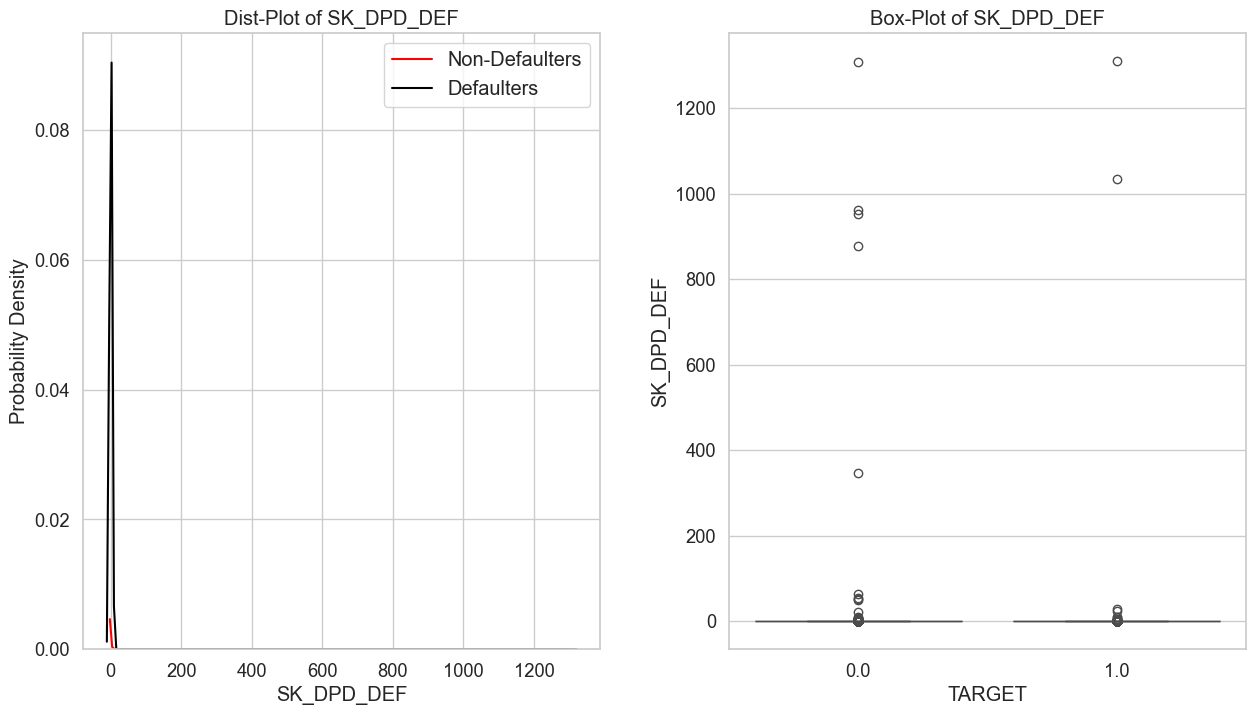

In [25]:
plot_continuous_variables(cc_balance_merged, 'SK_DPD_DEF', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `SK_DPD_DEF` (số ngày chậm trả nợ kể từ ngày thanh toán cuối cùng) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `SK_DPD_DEF` cho thấy phần lớn các khoản vay của cả hai nhóm có số ngày chậm trả nợ gần như bằng không, cho thấy hầu hết các khoản vay được trả đúng hạn.</li>
    <li>Biểu đồ phân phối (trái) chỉ ra sự tương đồng lớn về phân phối giữa người vỡ nợ và không vỡ nợ, với đỉnh chính của cả hai nhóm nằm gần giá trị 0. Tuy nhiên, có một số trường hợp ngoại lệ có `SK_DPD_DEF` rất cao trong nhóm vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) cho thấy rằng, trong khi mức trung bình của cả hai nhóm gần như bằng nhau và rất thấp, nhóm vỡ nợ có một số trường hợp ngoại lệ cao, phản ánh sự chậm trả nợ nghiêm trọng.</li>
</ol>

**Kết luận:**
- `SK_DPD_DEF` là một chỉ số quan trọng để đánh giá rủi ro tín dụng, cho thấy phần lớn các khoản vay được thanh toán đúng hạn.
- Các trường hợp chậm trả nợ nghiêm trọng được thể hiện qua các giá trị ngoại lệ cao có thể cần được xem xét chi tiết hơn để đánh giá và quản lý rủi ro tín dụng một cách hiệu quả.


# Boxplots for counts and financial variables with potential outliers

### **Phân phối của Biến Liên Tục `AMT_BALANCE`**

Cột này mô tả số dư hiện tại của tài khoản thẻ tín dụng.

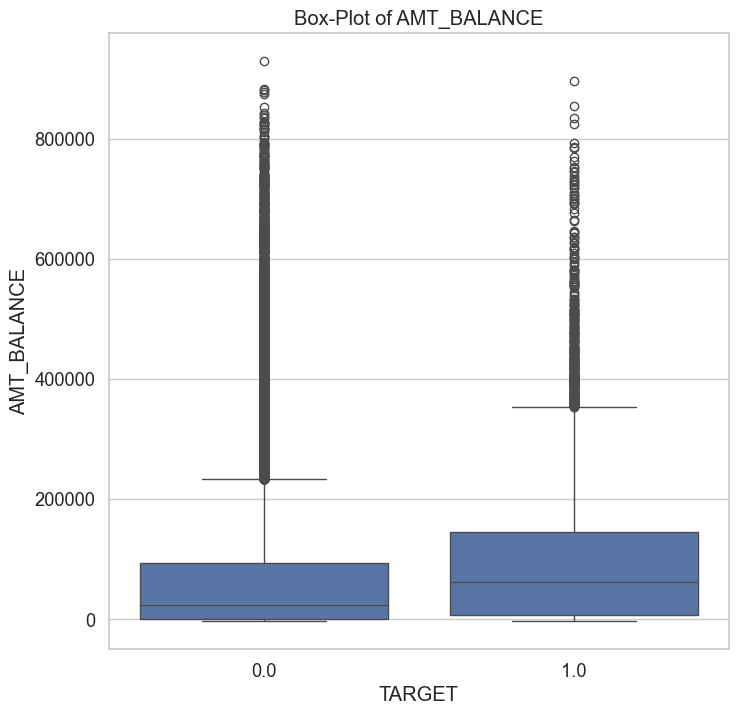

In [26]:
plot_continuous_variables(cc_balance_merged, 'AMT_BALANCE', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ trên cho thấy phân phối của `AMT_BALANCE` cho những người vỡ nợ (1) và không vỡ nợ (0). Dưới đây là những nhận định chính từ biểu đồ này:

<ol>
    <li>Những người vỡ nợ có giá trị `AMT_BALANCE` cao hơn so với những người không vỡ nợ. Điều này thể hiện qua giá trị cao hơn ở tất cả các phần trăm vị và phần "whiskers" của biểu đồ.</li>
    <li>Sự khác biệt này có thể ngụ ý rằng số tiền tín dụng của những người vỡ nợ cũng cao hơn tương đối so với những người không vỡ nợ, cho thấy một mức độ tiêu dùng và vay mượn cao hơn.</li>
    <li>Những người vỡ nợ cũng có khoản trả góp tối thiểu hàng tháng cao hơn, điều này phản ánh thói quen chi tiêu và vay mượn của họ, có thể là do việc quản lý tài chính kém hiệu quả hoặc do đầu tư vào các tài sản không mang lại lợi nhuận tốt.</li>
</ol>

**Kết luận:**
- Phân tích này cung cấp cái nhìn sâu sắc về mối liên hệ giữa số dư tài khoản tín dụng và rủi ro vỡ nợ. Các nhà quản lý tín dụng có thể cần cân nhắc điều chỉnh chính sách cấp tín dụng hoặc giám sát chặt chẽ hơn đối với các khách hàng có giá trị `AMT_BALANCE` cao để ngăn ngừa rủi ro vỡ nợ.


### **Phân phối của Biến Liên Tục `AMT_CREDIT_LIMIT_ACTUAL`**

Cột này mô tả hạn mức tín dụng thực tế được cấp cho tài khoản thẻ tín dụng.

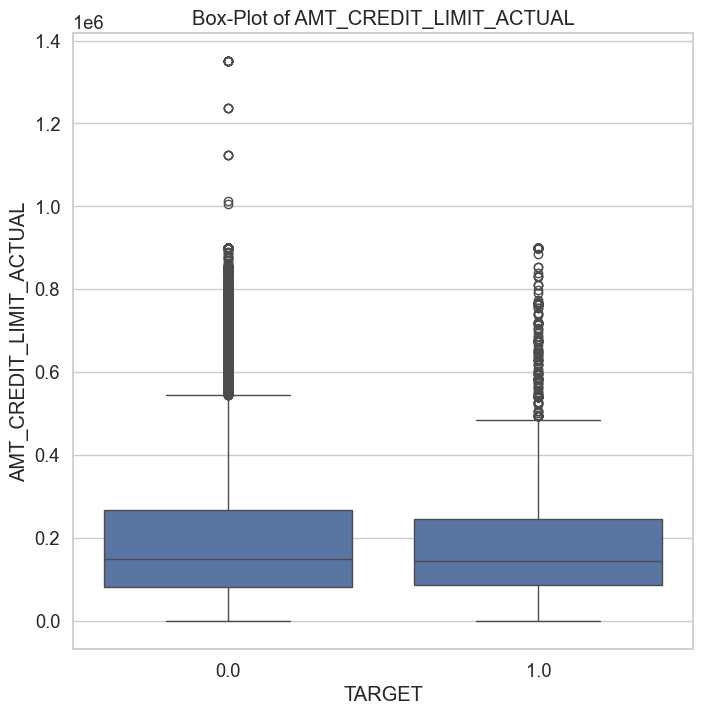

In [27]:
plot_continuous_variables(cc_balance_merged, 'AMT_CREDIT_LIMIT_ACTUAL', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận:**

Biểu đồ hộp trên cho thấy phân phối của giới hạn tín dụng thực tế (`AMT_CREDIT_LIMIT_ACTUAL`) cho hai nhóm khách hàng: không vỡ nợ (0) và vỡ nợ (1). Dưới đây là những nhận định chính từ biểu đồ này:

<ol>
    <li>Hầu hết các giới hạn tín dụng của nhóm không vỡ nợ có phân phối khá đồng đều và thấp hơn so với nhóm vỡ nợ, với phần lớn giá trị nằm trong khoảng thấp.</li>
    <li>Giới hạn tín dụng của nhóm vỡ nợ có nhiều điểm ngoại lệ với giới hạn tín dụng cao hơn đáng kể so với trung vị của nhóm, cho thấy sự phân bố rộng của giới hạn tín dụng trong nhóm này.</li>
    <li>Mặc dù có nhiều điểm ngoại lệ ở mức cao, nhóm vỡ nợ cũng có phần lớn giá trị giới hạn tín dụng tập trung ở mức thấp tương tự như nhóm không vỡ nợ.</li>
</ol>

**Kết luận:**
- Cả hai nhóm đều có xu hướng giữ giới hạn tín dụng ở mức thấp, nhưng nhóm vỡ nợ có nhiều trường hợp được cấp hạn mức cao hơn, có thể liên quan đến việc sử dụng tín dụng cao và rủi ro tín dụng cao hơn.
- Những điểm ngoại lệ ở nhóm vỡ nợ cho thấy có sự cần thiết cần xem xét kỹ lưỡng hơn đối với chính sách cấp tín dụng, đặc biệt là đối với những khách hàng có hồ sơ rủi ro cao.


### **Phân phối của Biến Liên Tục `CNT_DRAWINGS_CURRENT`**

Cột này mô tả tổng số tiền đã rút từ tài khoản thẻ tín dụng trong tháng hiện tại.

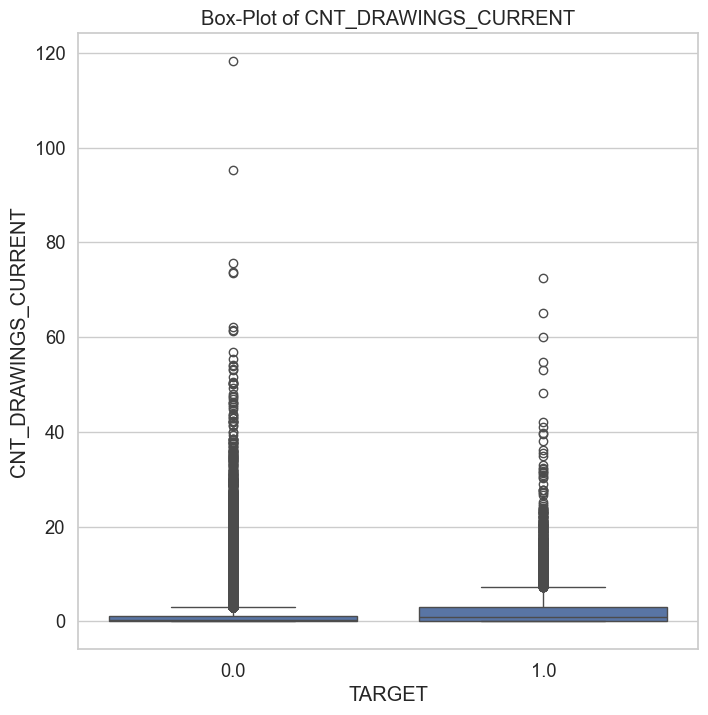

In [28]:
plot_continuous_variables(cc_balance_merged, 'CNT_DRAWINGS_CURRENT', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ trên cho thấy phân bổ của `CNT_DRAWINGS_CURRENT` cho những người vỡ nợ (1) và không vỡ nợ (0). Dưới đây là những nhận định chính từ biểu đồ này:

<ol>
    <li>Những người không vỡ nợ (0) có ít lần rút tiền (drawings) từ tài khoản tín dụng của họ so với những người vỡ nợ (1). Điều này thể hiện qua phạm vi thấp hơn và giá trị trung bình thấp hơn của biểu đồ.</li>
    <li>Tuy nhiên, những người vỡ nợ có một số điểm ngoại lệ cao, điều này cho thấy một số ít trong số họ có xu hướng rút tiền thường xuyên hơn hoặc rút số lượng lớn hơn một cách bất thường.</li>
    <li>Phân bố của `CNT_DRAWINGS_CURRENT` ở nhóm người vỡ nợ cho thấy họ có thể đang sử dụng tài khoản tín dụng của mình một cách tích cực hơn, có thể là để đối phó với khó khăn tài chính hoặc do quản lý tài chính kém.</li>
</ol>

**Kết luận:**
- Phân tích này cung cấp cái nhìn sâu sắc về mối liên hệ giữa số lần rút tiền từ tài khoản tín dụng và rủi ro vỡ nợ. Các nhà quản lý tín dụng có thể cần cân nhắc giám sát chặt chẽ hơn đối với hành vi rút tiền để ngăn ngừa rủi ro vỡ nợ.


### **Phân phối của Biến Liên Tục `CNT_DRAWINGS_OTHER_CURRENT`**

Cột này mô tả tổng số tiền đã rút qua các phương thức khác không phải ATM hoặc giao dịch mua hàng.

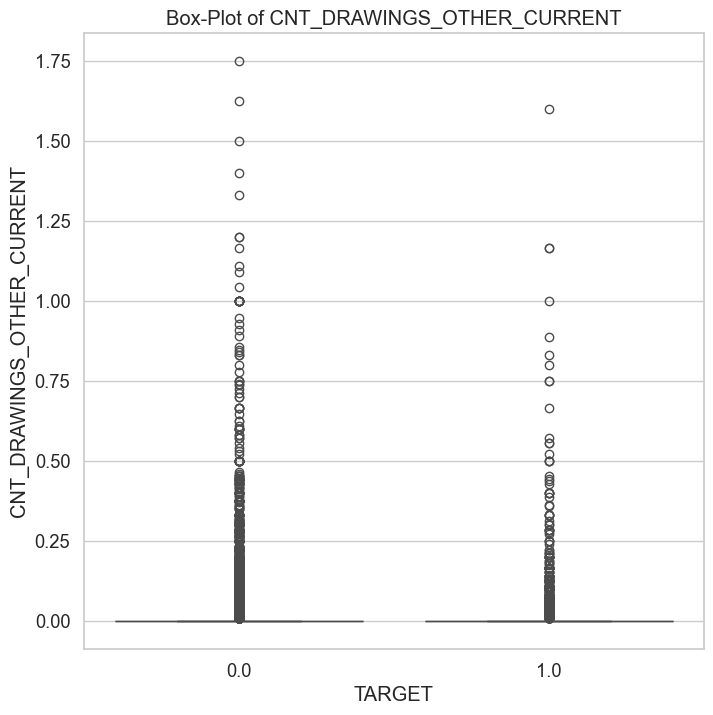

In [29]:
plot_continuous_variables(cc_balance_merged, 'CNT_DRAWINGS_OTHER_CURRENT', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ trên cho thấy sự phân bổ của `CNT_DRAWINGS_OTHER_CURRENT` cho nhóm không vỡ nợ (0) và vỡ nợ (1). Dưới đây là những nhận định chính từ biểu đồ này:

<ol>
    <li>Đối với cả hai nhóm, hầu hết các giao dịch rút tiền khác từ tài khoản tín dụng đều ít, với phần lớn các giá trị gần bằng không. Điều này cho thấy rằng rút tiền từ tài khoản tín dụng cho các mục đích khác không phải là một hành vi phổ biến.</li>
    <li>Các điểm ngoại lệ cho thấy có một số ít trường hợp cá biệt trong cả hai nhóm sử dụng tài khoản tín dụng của họ để thực hiện các giao dịch rút tiền khác, nhưng số lượng này không đáng kể.</li>
    <li>Không có sự khác biệt đáng kể về hành vi rút tiền khác giữa nhóm vỡ nợ và không vỡ nợ, điều này cho thấy hành vi này không liên quan mật thiết đến rủi ro vỡ nợ.</li>
</ol>

**Kết luận:**
- Phân tích này chỉ ra rằng không có mối liên hệ rõ ràng giữa số lần rút tiền cho các mục đích khác và việc vỡ nợ, điều này có thể hữu ích cho các nhà phân tích rủi ro trong việc đánh giá các yếu tố rủi ro khác.


### **Phân phối của Biến Liên Tục `CNT_DRAWINGS_POS_CURRENT`**

Cột này mô tả tổng số tiền đã được rút qua các giao dịch mua hàng tại các điểm bán hàng (POS).

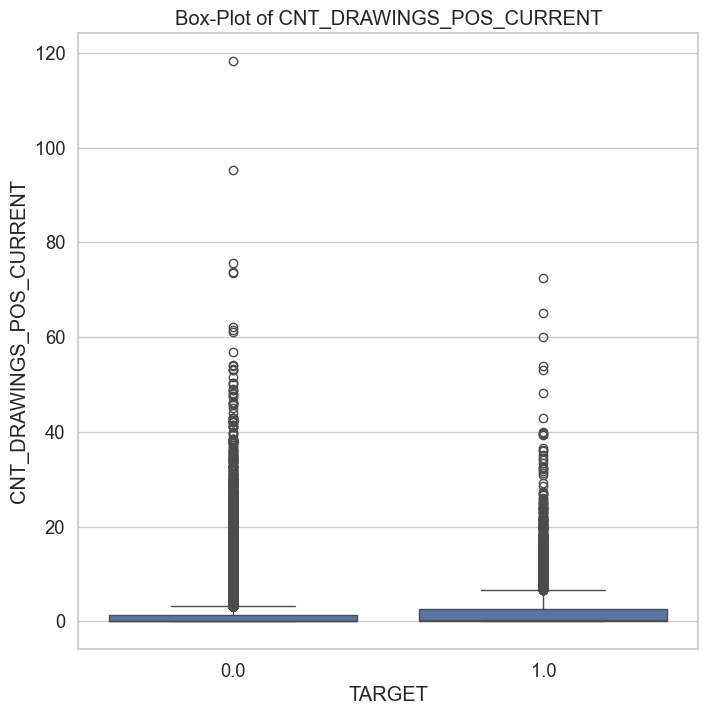

In [30]:
plot_continuous_variables(cc_balance_merged, 'CNT_DRAWINGS_POS_CURRENT', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ trên thể hiện sự phân bổ của `CNT_DRAWINGS_POS_CURRENT` giữa nhóm không vỡ nợ (0) và vỡ nợ (1). Những nhận định chính từ biểu đồ này:

<ol>
    <li>Số lượng giao dịch rút tiền tại điểm bán (POS) trong nhóm không vỡ nợ và vỡ nợ đều có xu hướng tương đối thấp, chủ yếu tập trung gần giá trị 0, nhưng có sự phân bổ rộng cho các giá trị cao hơn.</li>
    <li>Những người không vỡ nợ có các điểm ngoại lệ ít hơn so với nhóm vỡ nợ, chỉ ra rằng nhóm vỡ nợ có nhiều giao dịch rút tiền tại POS hơn.</li>
    <li>Tuy nhiên, điểm dữ liệu ngoại lệ cho thấy một số ít người trong cả hai nhóm thực hiện số lượng giao dịch tại POS cao bất thường, có thể chỉ ra một số trường hợp cụ thể về hành vi chi tiêu.</li>
</ol>

**Kết luận:**
- Những người vỡ nợ có thể có xu hướng sử dụng tín dụng của mình để thực hiện các giao dịch tại điểm bán nhiều hơn so với những người không vỡ nợ, điều này có thể gợi ý một mô hình chi tiêu đặc thù cần được xem xét kỹ lưỡng hơn trong các phân tích rủi ro tín dụng.


### **Phân phối của Biến Liên Tục `CNT_INSTALMENT_MATURE_CUM`**

Cột này mô tả số lượng trung bình các khoản trả góp đã được thanh toán trên các khoản vay trước đây.

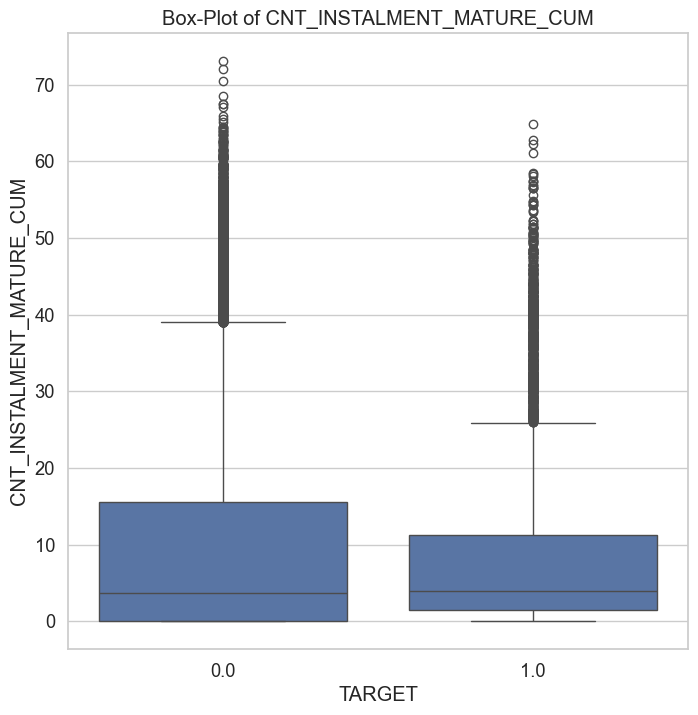

In [31]:
plot_continuous_variables(cc_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ trên cho thấy rằng những người không vỡ nợ thường có phạm vi giá trị cao hơn về số lượng các khoản trả góp đã thanh toán so với những người vỡ nợ. Điều này có thể phản ánh hành vi vỡ nợ, khi những người vỡ nợ thường trả ít khoản trả góp hơn trên các khoản vay trước đây của họ. 

<ol>
    <li>Các giá trị ngoại lệ cao trong cả hai nhóm cho thấy một số ít người dùng đã thanh toán một số lượng lớn các khoản trả góp, đặc biệt là trong nhóm không vỡ nợ.</li>
    <li>Điều này cũng có thể ám chỉ một cấu trúc tín dụng khác nhau giữa hai nhóm, với nhóm không vỡ nợ có khả năng tiếp cận và sử dụng các khoản vay lâu dài hơn hoặc có điều kiện tài chính ổn định hơn để trả nợ đúng hạn.</li>
    <li>Phát hiện này cung cấp thông tin hữu ích cho các nhà phân tích rủi ro tín dụng về mối liên hệ giữa tính năng thực thi nghĩa vụ tài chính và khả năng mặc định.</li>
</ol>

**Kết luận:**
- Mô hình thanh toán trả góp có thể dùng làm chỉ báo đáng tin cậy về rủi ro vỡ nợ, với những người có lịch sử thanh toán trả góp đều đặn ít có khả năng rơi vào tình trạng vỡ nợ.



### **Phân phối của Biến Liên Tục `CNT_DRAWINGS_ATM_CURRENT`**

Cột này mô tả số lượng giao dịch rút tiền từ ATM trong tháng hiện tại.

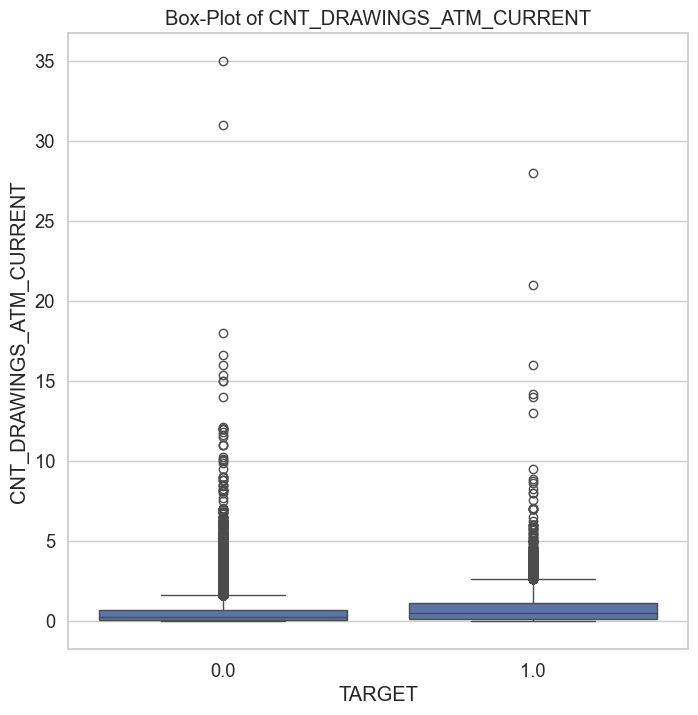

In [32]:
plot_continuous_variables(cc_balance_merged, 'CNT_DRAWINGS_ATM_CURRENT', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ này cho thấy phân phối số lần rút tiền mặt từ ATM của người vay trong kỳ báo cáo hiện tại, được phân loại theo tình trạng vỡ nợ (0 không vỡ nợ, 1 vỡ nợ). Có vài điểm quan sát được từ biểu đồ:

1. Phân phối của số lần rút tiền mặt từ ATM cho thấy không có sự khác biệt đáng kể về mặt tần suất rút tiền giữa nhóm vỡ nợ và không vỡ nợ. Cả hai nhóm đều cho thấy sự tập trung của các khoản rút tiền ở mức thấp, với số lần rút tiền trung bình là rất ít.
2. Các giá trị ngoại lệ chỉ ra rằng có những trường hợp cá biệt trong cả hai nhóm mà người vay rút tiền mặt từ ATM nhiều lần, điều này có thể liên quan đến các nhu cầu tài chính khẩn cấp hoặc sử dụng tín dụng để quản lý dòng tiền.
3. Cả hai nhóm đều có số lần rút tiền mặt tối đa không quá 35 lần trong kỳ báo cáo, điều này cho thấy hoạt động rút tiền mặt không thường xuyên xảy ra và không phải là yếu tố chính phân biệt giữa hai nhóm theo mặc định.

**Kết luận:**
- Mặc dù số lần rút tiền mặt từ ATM có thể là chỉ số về hành vi tiêu dùng cá nhân, nhưng dữ liệu hiện tại không cho thấy mối liên hệ rõ ràng giữa số lần rút tiền và khả năng vỡ nợ. Do đó, các nhà phân tích có thể cần xem xét các yếu tố khác bên cạnh số lần rút tiền từ ATM để đánh giá rủi ro tín dụng.



### **Phân phối của Biến Liên Tục `AMT_INST_MIN_REGULARITY`**

Cột này mô tả số tiền tối thiểu cần thanh toán theo lịch trình thường xuyên.

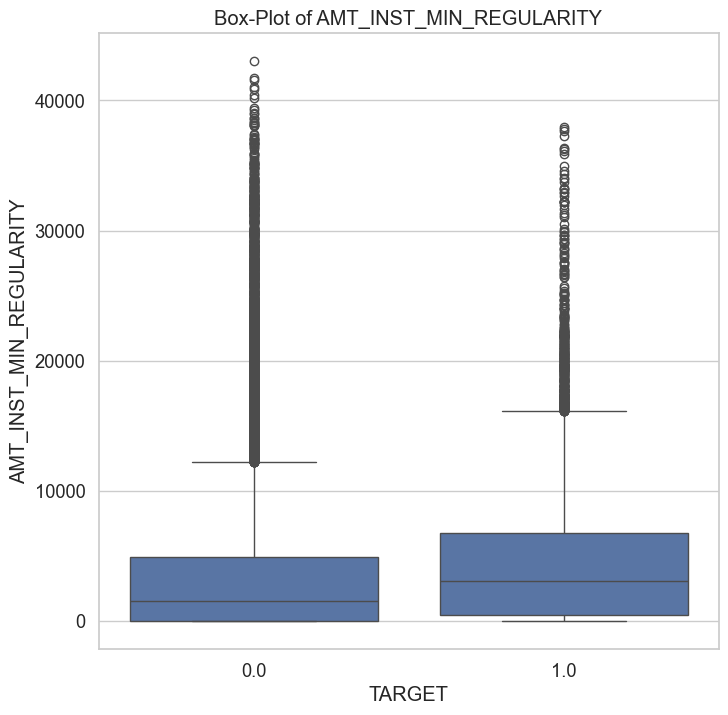

In [33]:
plot_continuous_variables(cc_balance_merged, 'AMT_INST_MIN_REGULARITY', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ này cho thấy phân phối của số tiền trả góp tối thiểu hàng tháng (`AMT_INST_MIN_REGULARITY`) giữa hai nhóm: những người không vỡ nợ (0) và những người vỡ nợ (1). Dựa trên các quan sát từ biểu đồ:

1. Cả hai nhóm đều có giá trị trung vị tương tự nhau, cho thấy số tiền trả góp tối thiểu hàng tháng không khác biệt nhiều giữa người vỡ nợ và không vỡ nợ. Điều này có thể ngụ ý rằng số tiền trả góp tối thiểu mỗi tháng không phải là yếu tố chính dẫn đến vỡ nợ.
2. Tuy nhiên, cả hai nhóm đều có sự xuất hiện của các giá trị ngoại lệ cao, với những giá trị này cao hơn nhiều so với phần lớn dữ liệu, cho thấy có một số trường hợp cá biệt có nghĩa vụ trả nợ tối thiểu hàng tháng cao bất thường.
3. Mặc dù phân bố giữa hai nhóm tương đối giống nhau, nhưng có một số điểm ngoại lệ cao hơn nhiều trong nhóm không vỡ nợ, điều này có thể cho thấy những người này có khả năng tài chính tốt hơn để xử lý các khoản trả lớn hơn.

**Kết luận:**
- Sự khác biệt về số tiền trả góp tối thiểu hàng tháng không có mối liên hệ rõ ràng với việc vỡ nợ. Để hiểu rõ hơn về các nguyên nhân và yếu tố ảnh hưởng đến việc vỡ nợ, cần phải xem xét thêm các yếu tố khác như thu nhập, chi tiêu hàng tháng và các khoản nợ khác.



### **Phân phối của Biến Liên Tục `AMT_PAYMENT_CURRENT`**

Cột này mô tả tổng số tiền đã thanh toán trong tháng hiện tại.

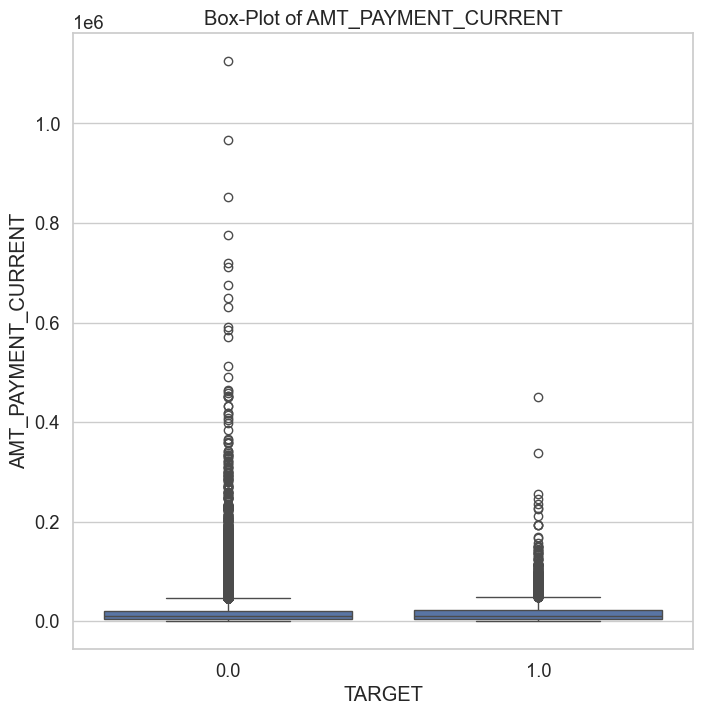

In [34]:
plot_continuous_variables(cc_balance_merged, 'AMT_PAYMENT_CURRENT', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ hộp này trình bày phân phối của số tiền thanh toán hiện tại (`AMT_PAYMENT_CURRENT`) giữa hai nhóm: những người không vỡ nợ (0) và những người vỡ nợ (1). Dựa trên các quan sát từ biểu đồ:

1. Sự phân bố của giá trị thanh toán hiện tại cho thấy rằng đa số các khoản thanh toán đều nằm trong phạm vi thấp, với rất ít các giá trị cao dưới dạng ngoại lệ, cho cả hai nhóm.
2. Nhóm không vỡ nợ (0) có phạm vi phân bố rộng hơn so với nhóm vỡ nợ (1), và có xu hướng có một số ngoại lệ cao hơn, cho thấy rằng có những người trong nhóm này thanh toán số tiền lớn hơn.
3. Nhóm vỡ nợ (1) có phạm vi và trung vị thấp hơn, điều này có thể cho thấy họ có khó khăn hơn trong việc duy trì mức thanh toán cao so với nhóm không vỡ nợ.

**Kết luận:**
- Phân tích này cho thấy sự khác biệt rõ rệt về khả năng thanh toán hiện tại giữa hai nhóm. Những người không vỡ nợ có khả năng thanh toán cao hơn, điều này có thể góp phần vào việc họ duy trì được tình trạng tài chính ổn định và tránh được việc vỡ nợ.


# Financial variables that show high correlations


### **Phân phối của Biến Liên Tục `AMT_RECEIVABLE_PRINCIPAL`**

Cột này mô tả tổng số tiền gốc phải thu từ khách hàng.


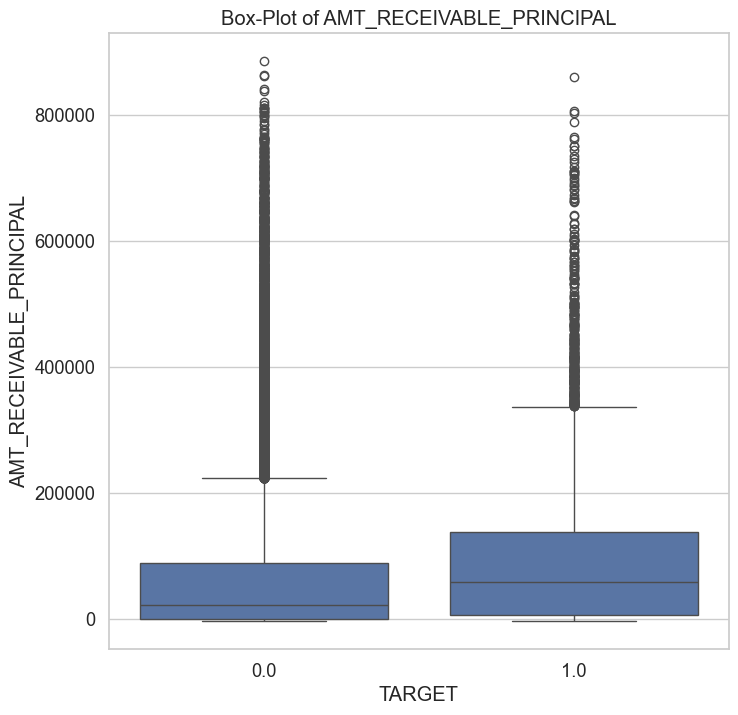

In [35]:
plot_continuous_variables(cc_balance_merged, 'AMT_RECEIVABLE_PRINCIPAL', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ hộp này thể hiện phân phối của `AMT_RECEIVABLE_PRINCIPAL` giữa hai nhóm: những người không vỡ nợ (0) và những người vỡ nợ (1). Dựa trên biểu đồ:

1. **Phân phối giá trị:**
   - Cả hai nhóm đều có trung vị và phân vị khá gần nhau, nhưng nhóm không vỡ nợ (0) có xu hướng có phạm vi rộng hơn một chút ở các giá trị cao.
   - Nhóm vỡ nợ (1) có phân bố hẹp hơn và ít ngoại lệ hơn so với nhóm không vỡ nợ.

2. **Ngoại lệ:**
   - Cả hai nhóm đều có một số giá trị rất cao (trên 600.000), nhưng những giá trị này nằm trong phạm vi của nhóm không vỡ nợ.

**Kết luận:**
- Giá trị `AMT_RECEIVABLE_PRINCIPAL` không thể hiện sự khác biệt lớn giữa hai nhóm, nhưng nhóm không vỡ nợ dường như có phạm vi giá trị rộng hơn một chút. Điều này có thể chỉ ra rằng các cá nhân trong nhóm không vỡ nợ thường vay các khoản tín dụng lớn hơn hoặc có các khoản nợ được quản lý tốt hơn.



### **Phân phối của Biến Liên Tục `AMT_RECIVABLE`**

Cột này mô tả tổng số tiền còn phải thu từ khách hàng (bao gồm cả gốc và lãi).

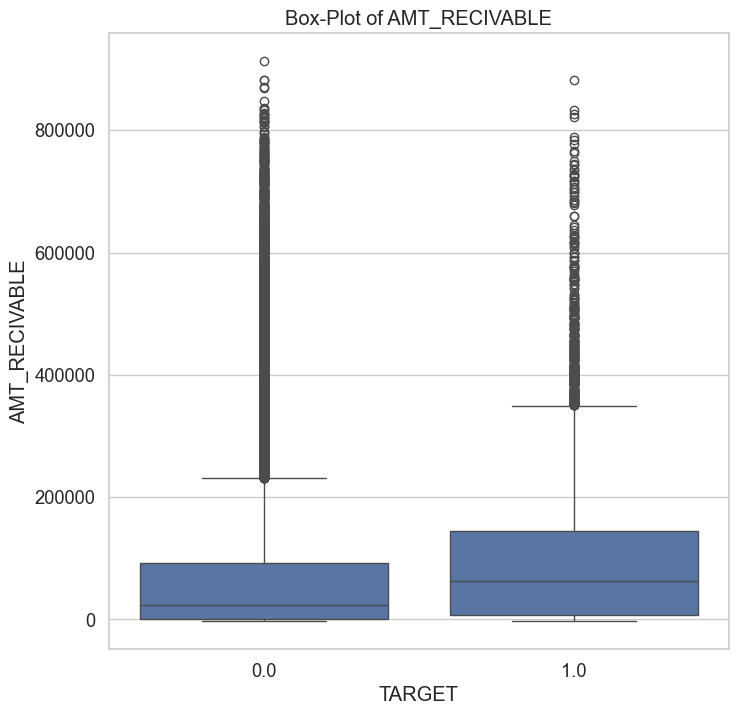

In [36]:
plot_continuous_variables(cc_balance_merged, 'AMT_RECIVABLE', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ hộp này minh họa phân phối của `AMT_RECIVABLE` giữa hai nhóm: những người không vỡ nợ (0) và những người vỡ nợ (1). 

1. **Phân bố giá trị:**
   - Cả hai nhóm đều có trung vị gần nhau và các phần tử ngoại lệ trải rộng ở giá trị cao hơn.
   - Nhóm không vỡ nợ (0) có phạm vi giá trị rộng hơn ở phần "whiskers" so với nhóm vỡ nợ (1), cho thấy rằng một số cá nhân trong nhóm không vỡ nợ có giá trị `AMT_RECIVABLE` lớn hơn.

2. **Ngoại lệ:**
   - Cả hai nhóm đều xuất hiện những giá trị ngoại lệ rất lớn (trên 600.000). Tuy nhiên, số lượng ngoại lệ cao hơn một chút trong nhóm không vỡ nợ.

**Kết luận:**
- Nhóm không vỡ nợ (0) có xu hướng có giá trị `AMT_RECIVABLE` cao hơn so với nhóm vỡ nợ (1). Điều này có thể chỉ ra rằng những người không vỡ nợ thường có khả năng quản lý và trả nợ tốt hơn, mặc dù giá trị khoản tín dụng còn lại của họ có thể cao hơn.



### **Phân phối của Biến Liên Tục `AMT_TOTAL_RECEIVABLE`**

Cột này mô tả tổng số tiền khách hàng còn nợ (bao gồm cả gốc, lãi và phí).

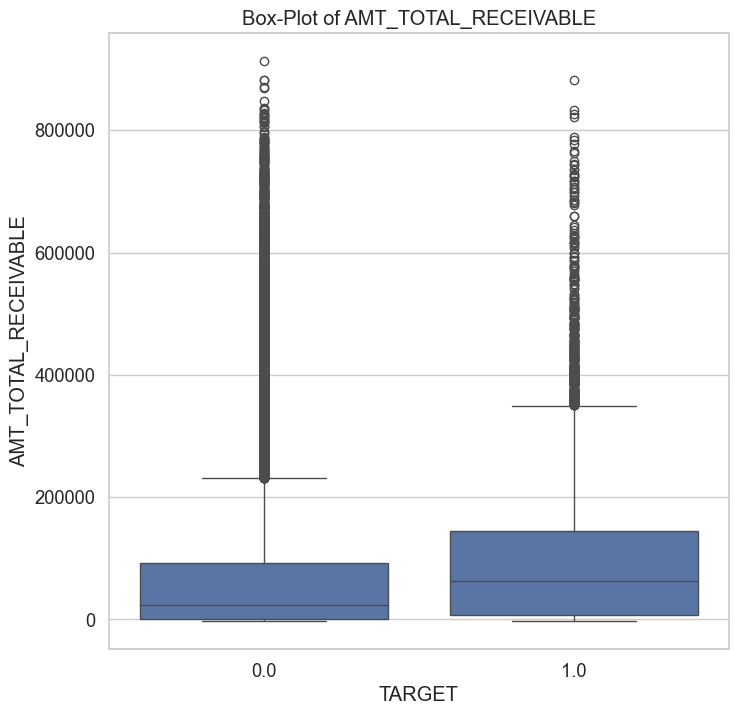

In [37]:
plot_continuous_variables(cc_balance_merged, 'AMT_TOTAL_RECEIVABLE', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Quan sát biểu đồ hộp của `AMT_TOTAL_RECEIVABLE`, chúng ta thấy một hành vi tương tự như các giá trị số tiền khác, đó là những người vỡ nợ thường có số tiền phải thu cao hơn trên khoản vay trước đây của họ, điều này có thể ngụ ý rằng họ đã vay những khoản tín dụng lớn hơn. Biểu đồ mật độ xác suất (PDF) cũng cho thấy một đỉnh cao hơn đáng kể ở các giá trị thấp đối với những người không vỡ nợ so với những người vỡ nợ.

**Kết luận:**
- Nhóm không vỡ nợ (0) thường có giá trị `AMT_TOTAL_RECEIVABLE` cao hơn so với nhóm vỡ nợ (1). Điều này có thể cho thấy rằng những người không vỡ nợ thường có khả năng quản lý các khoản nợ lớn hơn, mặc dù họ vẫn nợ tổng số tiền lớn.








### **Phân phối của Biến Liên Tục `AMT_DRAWINGS_ATM_CURRENT`**

Cột này mô tả tổng số giao dịch rút tiền đã thực hiện trong tháng hiện tại.

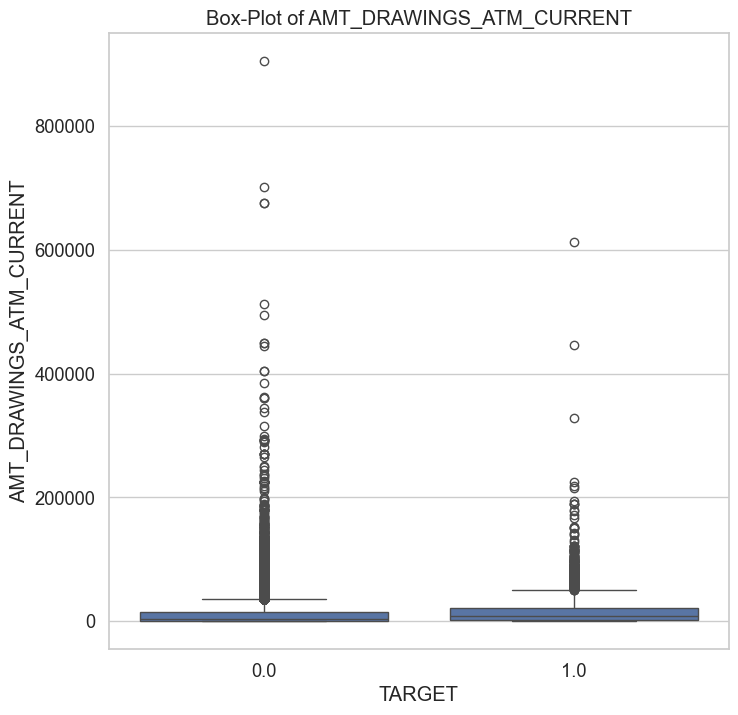

In [38]:
plot_continuous_variables(cc_balance_merged, 'AMT_DRAWINGS_ATM_CURRENT', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ hộp này minh họa phân phối của `AMT_DRAWINGS_ATM_CURRENT` giữa hai nhóm: những người không vỡ nợ (0) và những người vỡ nợ (1).

1. **Phân bố giá trị:**
   - Cả hai nhóm đều có trung vị tương đối thấp và gần như tương đồng.
   - Phần "whiskers" và các giá trị ngoại lệ chỉ ra rằng một số cá nhân trong cả hai nhóm thực hiện giao dịch ATM với số tiền rất lớn.

2. **Ngoại lệ:**
   - Có một số lượng lớn giá trị ngoại lệ trong cả hai nhóm, với các giao dịch lên đến trên 800.000. Nhóm không vỡ nợ (0) có ngoại lệ lớn hơn so với nhóm vỡ nợ (1).

**Kết luận:**
- `AMT_DRAWINGS_ATM_CURRENT` dường như không phải là yếu tố quyết định rõ ràng giữa hai nhóm. Tuy nhiên, các giao dịch lớn hơn thường xuất hiện ở nhóm không vỡ nợ (0), điều này có thể cho thấy họ có khả năng sử dụng tiền mặt thông qua ATM cao hơn.



### **Phân phối của Biến Liên Tục `AMT_DRAWINGS_CURRENT`**

Cột này mô tả tổng số giao dịch rút tiền đã thực hiện trong tháng hiện tại.

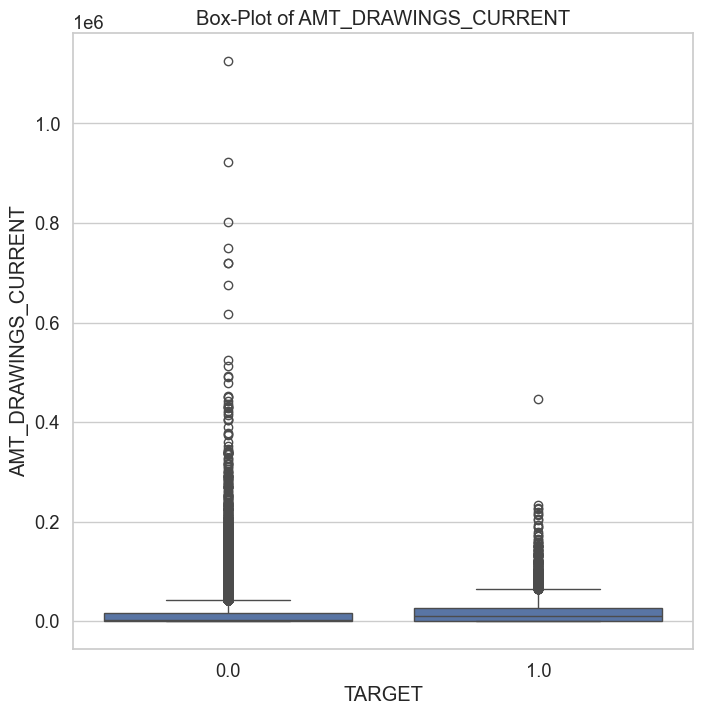

In [39]:
plot_continuous_variables(cc_balance_merged, 'AMT_DRAWINGS_CURRENT', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ hộp này minh họa phân phối của `AMT_DRAWINGS_CURRENT` giữa hai nhóm: những người không vỡ nợ (0) và những người vỡ nợ (1).

1. **Phân bố giá trị:**
   - Trung vị của cả hai nhóm khá thấp, cho thấy hầu hết các cá nhân thực hiện số tiền rút không đáng kể.
   - Tuy nhiên, nhóm không vỡ nợ (0) có các giá trị ngoại lệ lớn hơn nhiều so với nhóm vỡ nợ (1).

2. **Ngoại lệ:**
   - Nhóm không vỡ nợ (0) xuất hiện nhiều giá trị rút tiền vượt trên 800.000, trong khi nhóm vỡ nợ (1) có ngoại lệ nhưng không cao bằng.

**Kết luận:**
- `AMT_DRAWINGS_CURRENT` có thể liên quan đến khả năng thanh toán và mức độ sử dụng tín dụng của các cá nhân. Nhóm không vỡ nợ có xu hướng thực hiện các giao dịch lớn hơn, cho thấy họ có khả năng quản lý tài chính tốt hơn.



### **Phân phối của Biến Liên Tục `AMT_DRAWINGS_OTHER_CURRENT`**

Cột này mô tả tổng số giao dịch rút tiền đã thực hiện trong tháng hiện tại.

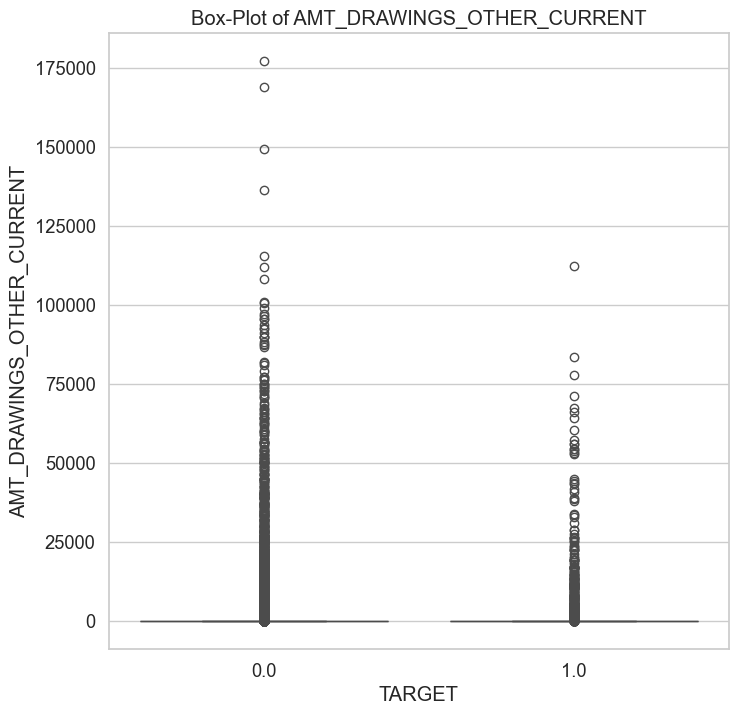

In [40]:
plot_continuous_variables(cc_balance_merged, 'AMT_DRAWINGS_OTHER_CURRENT', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ hộp này minh họa phân phối của `AMT_DRAWINGS_OTHER_CURRENT` giữa hai nhóm: những người không vỡ nợ (0) và những người vỡ nợ (1).

1. **Phân bố giá trị:**
   - Trung vị của cả hai nhóm rất thấp, gần như tiệm cận 0. Điều này chỉ ra rằng phần lớn người dùng không thường xuyên thực hiện các khoản rút tiền "khác".
   - Nhóm không vỡ nợ (0) có nhiều giá trị ngoại lệ cao hơn đáng kể so với nhóm vỡ nợ (1).

2. **Ngoại lệ:**
   - Nhóm không vỡ nợ xuất hiện các giá trị ngoại lệ vượt trên 150,000, trong khi nhóm vỡ nợ hiếm khi vượt qua ngưỡng này.

**Kết luận:**
- Các khoản rút tiền "khác" có thể không phải là một yếu tố chính quyết định hành vi vỡ nợ, nhưng sự hiện diện của các giá trị ngoại lệ ở nhóm không vỡ nợ có thể gợi ý rằng nhóm này có khả năng quản lý tài chính tốt hơn, ngay cả khi thực hiện các khoản rút tiền lớn bất thường.



### **Phân phối của Biến Liên Tục `AMT_DRAWINGS_POS_CURRENT`**

Cột này mô tả tổng số giao dịch rút tiền đã thực hiện trong tháng hiện tại.

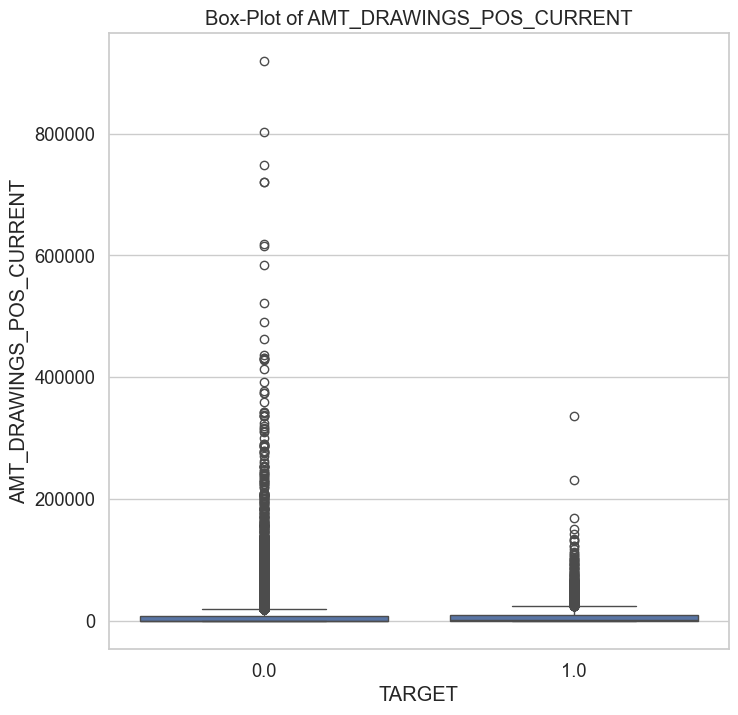

In [41]:
plot_continuous_variables(cc_balance_merged, 'AMT_DRAWINGS_POS_CURRENT', plots=['box'], figsize=(8,8))

##### **Quan sát và Kết luận**

Biểu đồ hộp này thể hiện phân phối của `AMT_DRAWINGS_POS_CURRENT` giữa hai nhóm: những người không vỡ nợ (0) và những người vỡ nợ (1).

1. **Phân bố giá trị:**
   - Trung vị ở cả hai nhóm gần như tương đương và nằm gần giá trị 0, cho thấy phần lớn khách hàng không sử dụng hoặc chỉ thực hiện rất ít các giao dịch qua POS (Point of Sale).
   - Tuy nhiên, nhóm không vỡ nợ (0) có phạm vi giá trị lớn hơn và nhiều ngoại lệ hơn so với nhóm vỡ nợ (1).

2. **Ngoại lệ:**
   - Các giá trị ngoại lệ trong nhóm không vỡ nợ có thể vượt quá 600,000, trong khi ở nhóm vỡ nợ hiếm khi vượt qua 200,000.

**Kết luận:**
- Những người không vỡ nợ có xu hướng thực hiện nhiều giao dịch qua POS hơn so với những người vỡ nợ, điều này có thể ngụ ý rằng họ sử dụng tài khoản tín dụng của mình cho các giao dịch hàng ngày một cách có tổ chức và hiệu quả hơn.
